# ✂️ Model Pruning: Odchudzanie Sieci

Większość wag w sieci neuronowej jest bliska zeru i nie wnosi nic do decyzji.
Możemy je usunąć (ustawić na stałe 0).

**Rodzaje Pruningu:**
1.  **Unstructured (Niestrukturalny):** Zerujemy pojedyncze wagi, gdziekolwiek są małe.
    *   *Zaleta:* Można usunąć bardzo dużo wag (np. 95%).
    *   *Wada:* Karty graficzne tego nie lubią (macierze rzadkie są trudne do obliczania).
2.  **Structured (Strukturalny):** Zerujemy całe neurony lub kanały.
    *   *Zaleta:* Model fizycznie przyspiesza (mniejsze macierze).
    *   *Wada:* Trudniej utrzymać jakość (Accuracy).

W tym notatniku zastosujemy **Global Unstructured Pruning**. Usuniemy 50% wag z całej sieci i zobaczymy, czy nadal rozpoznaje cyfry.

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64

# Prosty model (LeNet-style)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net().to(DEVICE)
print("Model gotowy. Na razie jest pełny (gęsty).")

Model gotowy. Na razie jest pełny (gęsty).


## Trening Bazowy

Najpierw musimy nauczyć sieć czegokolwiek, żeby miała co tracić.
Szybki trening na MNIST.

In [2]:
# Dane
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(epochs=1):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def evaluate():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return 100. * correct / len(test_loader.dataset)

print("🚀 Trenowanie modelu bazowego...")
train(epochs=2)
acc_original = evaluate()
print(f"Accuracy przed cięciem: {acc_original:.2f}%")

🚀 Trenowanie modelu bazowego...
Accuracy przed cięciem: 97.36%


## Pruning (Cięcie)

Użyjemy `torch.nn.utils.prune`.
Zastosujemy strategię **L1 Unstructured**:
*"Znajdź 50% wag o najmniejszej wartości bezwzględnej (najbliższych zera) i je zabij".*

PyTorch nie usuwa wag fizycznie (bo to zepsułoby strukturę tensora).
Tworzy **Maskę (0/1)**. Waga staje się `weight_orig * mask`.

In [3]:
# Wybieramy warstwy do przycięcia (wszystkie liniowe)
parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

# Tniemy 50% najsłabszych połączeń GLOBALNIE (czyli może usunąć więcej z fc1 niż z fc3)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5, # 50% do usunięcia
)

print("✂️ Przycięto 50% wag.")

# Sprawdźmy rzadkość (Sparsity)
def measure_sparsity(model):
    sum_zeros = 0
    sum_elements = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            sum_zeros += torch.sum(module.weight == 0)
            sum_elements += module.weight.nelement()
    return 100. * sum_zeros / sum_elements

print(f"Globalna rzadkość modelu: {measure_sparsity(model):.2f}%")
# Powinno być 50% (lub blisko, bo globalnie)

✂️ Przycięto 50% wag.
Globalna rzadkość modelu: 50.00%


## Wizualizacja: Co się stało z wagami?

Narysujemy histogram wag.
Powinieneś zobaczyć normalny rozkład (Gauusa), ale z **ogromną dziurą w środku** (na zerze).
To są te usunięte wagi.

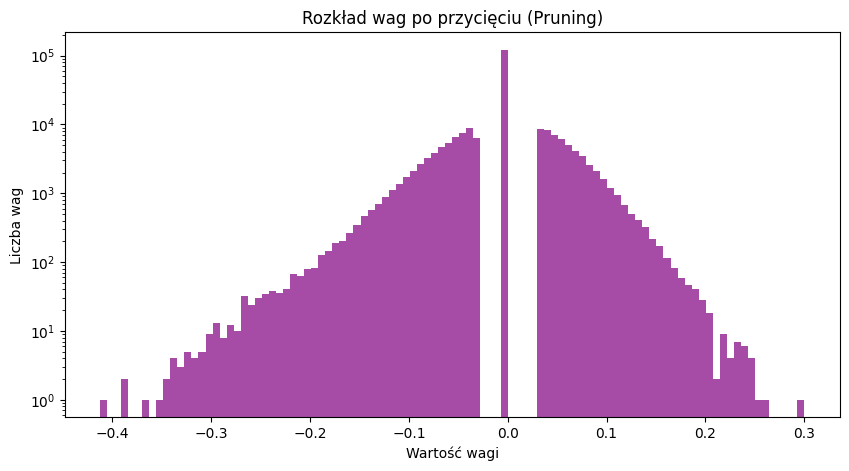

Widzisz? Wagi bliskie 0 zniknęły (są dokładnie zerem).


In [4]:
# Wizualizacja wag warstwy fc1
weights = model.fc1.weight.data.cpu().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.hist(weights, bins=100, color='purple', alpha=0.7)
plt.title("Rozkład wag po przycięciu (Pruning)")
plt.xlabel("Wartość wagi")
plt.ylabel("Liczba wag")
plt.yscale('log') # Skala logarytmiczna, żeby lepiej widzieć
plt.show()

print("Widzisz? Wagi bliskie 0 zniknęły (są dokładnie zerem).")

In [5]:
# Sprawdźmy, czy model zgłupiał
acc_pruned = evaluate()

print("-" * 30)
print(f"Accuracy Oryginał: {acc_original:.2f}%")
print(f"Accuracy Po cięciu (50%): {acc_pruned:.2f}%")

if acc_original - acc_pruned < 2.0:
    print("✅ SUKCES! Usunęliśmy połowę mózgu, a on dalej działa!")
else:
    print("⚠️ Spadek jakości. Trzeba by zrobić Fine-Tuning (dotrenować resztę wag).")
    
# Fizyczne usunięcie masek (uczynienie zmian trwałymi)
for module, param in parameters_to_prune:
    prune.remove(module, param)
    
print("Maski scalone z wagami. Model jest gotowy do zapisu.")

------------------------------
Accuracy Oryginał: 97.36%
Accuracy Po cięciu (50%): 97.37%
✅ SUKCES! Usunęliśmy połowę mózgu, a on dalej działa!
Maski scalone z wagami. Model jest gotowy do zapisu.


## 🧠 Podsumowanie: Loteria Biletowa

Dlaczego to działa?
Istnieje **Hipoteza Biletów na Loterię (Lottery Ticket Hypothesis)**.
Mówi ona, że w dużej, losowej sieci neuronowej istnieje **mała pod-sieć**, która po wytrenowaniu działa tak samo dobrze jak duża. Reszta to "przegrane losy", które są zbędne.

Pruning pozwala nam znaleźć ten "zwycięski los".

**Zastosowanie:**
1.  Połącz Pruning (usuwanie zer) z kompresją pliku (zip/sparse tensors).
2.  Twój model 100MB zmieni się w 10MB.
3.  Idealne do wysyłania aktualizacji aplikacji mobilnych (mniejszy download).